In [1]:
import pandas as pd

features_df = pd.read_csv("/home/j.maragall/Pipeline_CellMapping/membership_good_filtered_glom_features.csv")

(6907, 628)

In [3]:
features_df.columns

Index(['channel_0_mean', 'channel_0_std', 'channel_0_variance',
       'channel_0_entropy', 'channel_1_mean', 'channel_1_std',
       'channel_1_variance', 'channel_1_entropy', 'channel_2_mean',
       'channel_2_std',
       ...
       'channel_43_sum_intensity', 'centroid_x', 'centroid_y', 'orientation',
       'minr', 'minc', 'maxr', 'maxc', 'shape_label', 'glomerulus'],
      dtype='object', length=628)

In [9]:
final_features_df["closest_glomerular_shape"].unique()

array([ 45., 174.,  nan, 217., 144.,  85.,   1., 125., 172.,  29., 104.,
        96., 208.,  13.,  76.,  40., 210.])

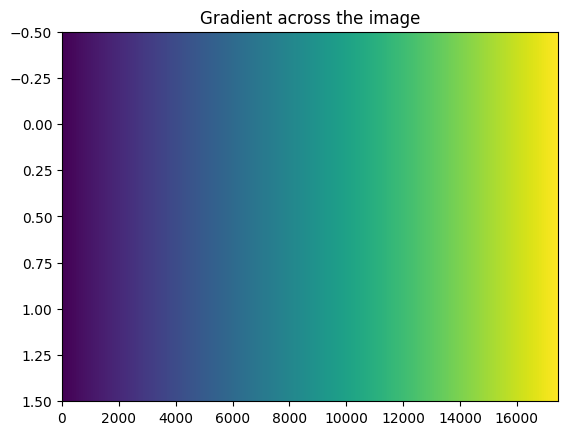

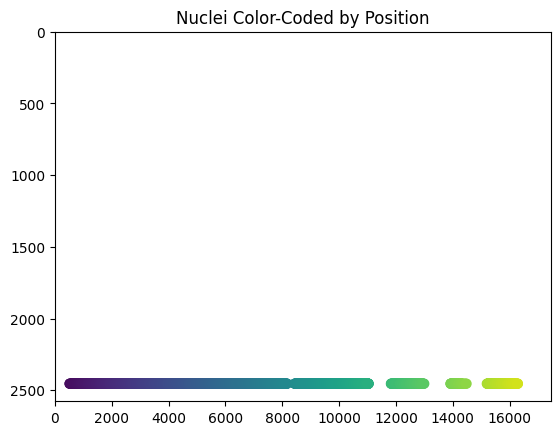

   channel_0_mean  channel_0_std  channel_0_variance  channel_0_entropy  \
0       170.15775      36.602623           1339.7520           3.954552   
1       134.39032      47.436810           2250.2510           4.654524   
2       151.42206      53.155598           2825.5176           4.304843   
3       177.96237      38.354300           1471.0524           3.760663   
4       173.95483      37.256280           1388.0303           3.546367   

   channel_1_mean  channel_1_std  channel_1_variance  channel_1_entropy  \
0             0.0            0.0                 0.0                0.0   
1             0.0            0.0                 0.0                0.0   
2             0.0            0.0                 0.0                0.0   
3             0.0            0.0                 0.0                0.0   
4             0.0            0.0                 0.0                0.0   

   channel_2_mean  channel_2_std  ...  centroid_x  centroid_y  orientation  \
0       21.336310   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import tiffslide as openslide
from PIL import Image
import cv2

# Load the features
features_df = pd.read_csv("/home/j.maragall/Pipeline_CellMapping/membership_good_filtered_glom_features.csv")

def normalize_mask(image, target_dtype=np.uint8):
    normalized_image = cv2.normalize(image, None, 0, np.iinfo(target_dtype).max, cv2.NORM_MINMAX)
    return normalized_image.astype(target_dtype)

# Open the slide and normalize it
read_DAPI = openslide.open_slide("/blue/pinaki.sarder/j.maragall/CellMapping/15-1 Stitch.tif")
DAPI_mask = normalize_mask(np.array(read_DAPI.get_thumbnail(read_DAPI.dimensions)), np.uint8)

# Desired dimensions
desired_width = 4908
desired_height = 17448

# Resizing the image
DAPI_mask = cv2.resize(DAPI_mask, (desired_width, desired_height), interpolation=cv2.INTER_LINEAR)

# Rotating and flipping the image for correct orientation
DAPI_mask = np.rot90(DAPI_mask)
DAPI_mask = np.flipud(DAPI_mask)

# Load the centroids data
centroids = features_df[['centroid_x', 'centroid_y']].values

# Create a gradient across the image
fig, ax = plt.subplots()
gradient = np.linspace(0, 1, DAPI_mask.shape[1])  # Changed to DAPI_mask.shape[1] for width
gradient = np.vstack((gradient, gradient))

# Display the gradient
ax.imshow(gradient, aspect='auto', cmap='viridis')
ax.set_title('Gradient across the image')
plt.show()

# Normalize the x-coordinates of centroids to the width of the image
norm = Normalize(0, DAPI_mask.shape[1])  # Changed to DAPI_mask.shape[1] for width
normalized_x = norm(centroids[:, 0])

# Create a colormap
cmap = plt.get_cmap('viridis')

# Map the normalized x-coordinates to the colormap
colors = cmap(normalized_x)

# Plotting the nuclei on the gradient with their colors
fig, ax = plt.subplots()
ax.imshow(gradient, aspect='auto', cmap='viridis')
ax.scatter(centroids[:, 0], [DAPI_mask.shape[0] / 2] * len(centroids), color=colors, s=40)  # y-position set to middle of the height
ax.set_title('Nuclei Color-Coded by Position')
plt.show()


# Convert the colors to hexadecimal format
hex_colors = ['#%02x%02x%02x' % (int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in colors]

# Add the colors as a new column in the DataFrame
features_df['color'] = hex_colors

 #head of the DataFrame to verify
print(features_df.head())

# If further steps are required to apply these changes to the image or save results, let me know!


In [17]:
X.shape 

(6907, 619)

/apps/jupyter/6.5.4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-29 14:39:59.394408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 14:40:03.966296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


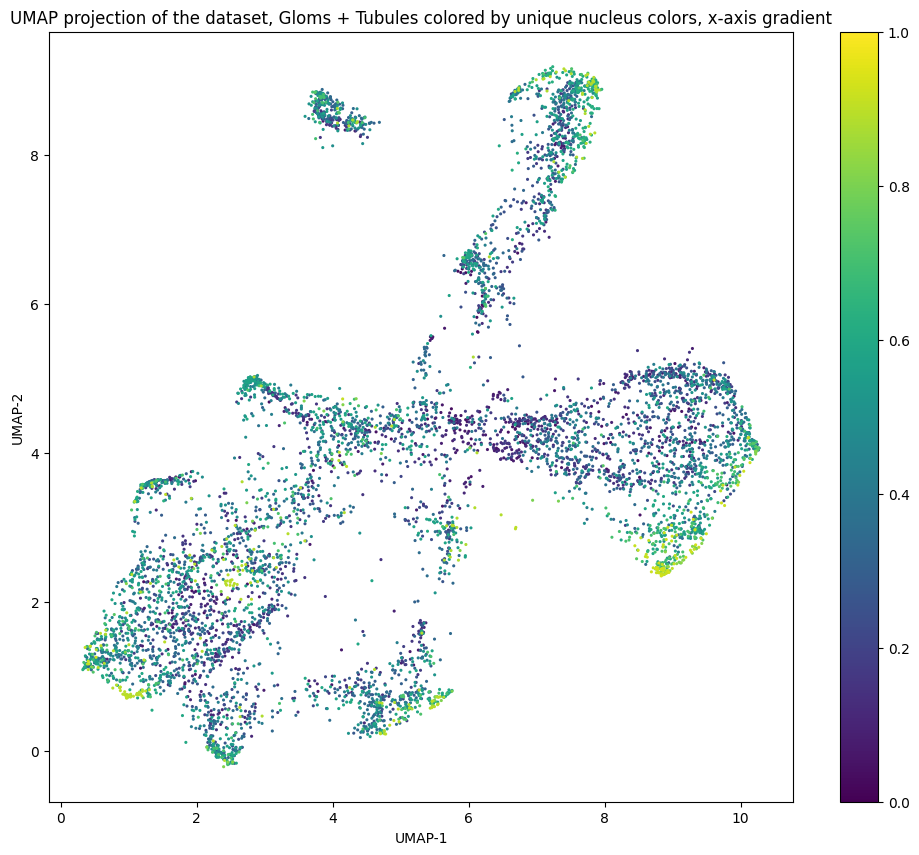

In [2]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Select features for UMAP (assuming you want to exclude non-numeric or ID columns)
# This part depends heavily on the structure of your CSV, here I assume all columns except 'centroid_x', 'centroid_y', and 'color' are features
feature_columns = [col for col in features_df.columns if col not in ["orientation", "shape_label", "minc", "maxc","minr","maxr","glomerulus", 'centroid_x', 'centroid_y', 'color']]
X = features_df[feature_columns].values

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the features
X_scaled = scaler.fit_transform(X)
# Initialize UMAP
reducer = umap.UMAP(n_neighbors=120, min_dist=0, n_components=2, metric="cosine")

# Fit and transform the data
embedding = reducer.fit_transform(X)

# Plot the results, color-coded by the unique color assigned to each nucleus
plt.figure(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=features_df['color'], s=5, edgecolor='none')
plt.title('UMAP projection of the dataset, Gloms + Tubules colored by unique nucleus colors, x-axis gradient')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.colorbar()  # Optional, if you want to show a color bar, though it might not be useful here
plt.show()


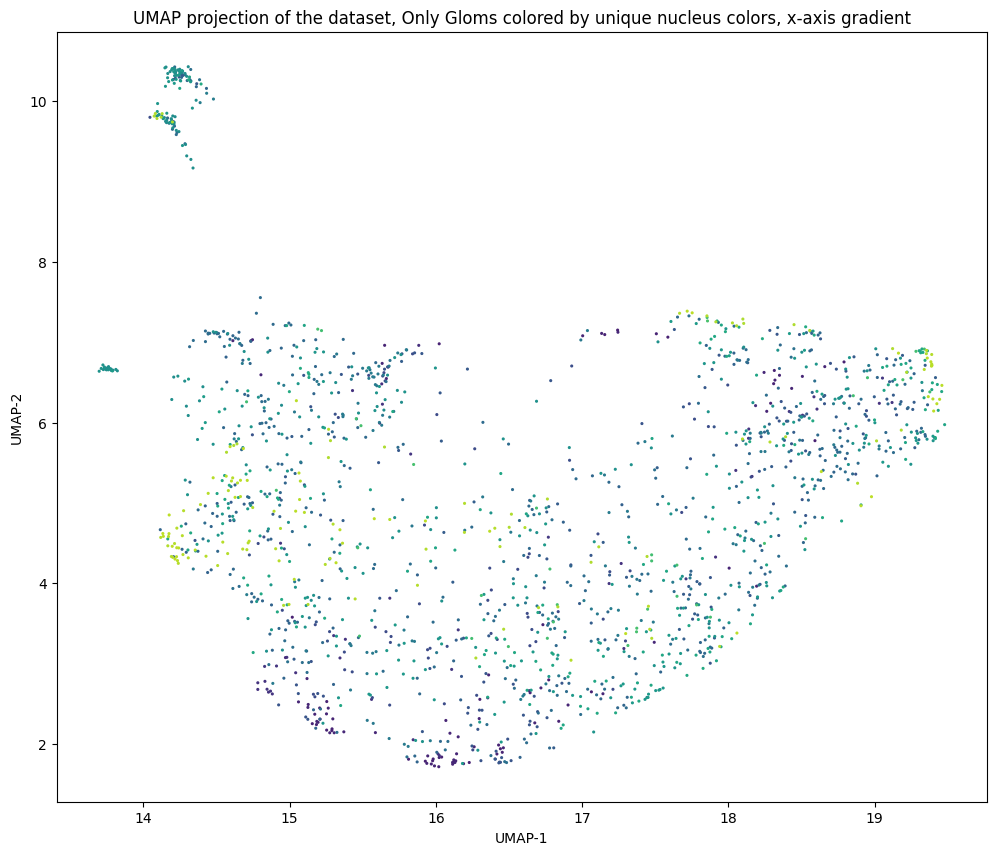

In [40]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Filter the DataFrame for rows where 'glomerulus' is 1
glomerulus_df = features_df[features_df['glomerulus'] == 1]

# Select features for UMAP (assuming you want to exclude non-numeric or ID columns)
feature_columns = [col for col in glomerulus_df.columns if col not in ["orientation", "shape_label", "minc", "maxc","minr","maxr","glomerulus", 'centroid_x', 'centroid_y', 'color']]
X = glomerulus_df[feature_columns].values

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the features
X_scaled = scaler.fit_transform(X)

# Initialize UMAP with cosine distance as the metric
reducer = umap.UMAP(n_neighbors=120, min_dist=0, n_components=2, metric="cosine")

# Fit and transform the scaled data
embedding = reducer.fit_transform(X_scaled)

# Plot the results, color-coded by the unique color assigned to each nucleus from the filtered data
plt.figure(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=glomerulus_df['color'], s=5, edgecolor='none')
plt.title('UMAP projection of the dataset, Only Gloms colored by unique nucleus colors, x-axis gradient')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()


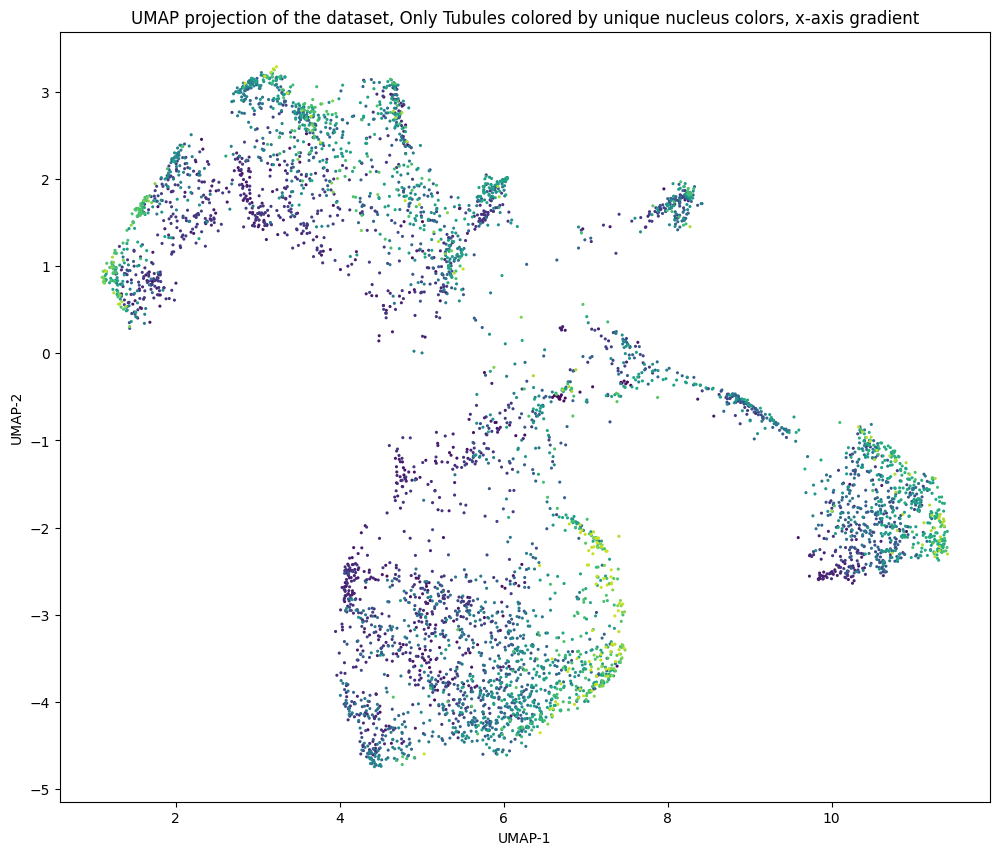

In [41]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Filter the DataFrame for rows where 'glomerulus' is 1
glomerulus_df = features_df[features_df['glomerulus'] == 0]

# Select features for UMAP (assuming you want to exclude non-numeric or ID columns)
feature_columns = [col for col in glomerulus_df.columns if col not in ["orientation", "shape_label", "minc", "maxc","minr","maxr","glomerulus", 'centroid_x', 'centroid_y', 'color']]
X = glomerulus_df[feature_columns].values

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the features
X_scaled = scaler.fit_transform(X)

# Initialize UMAP with cosine distance as the metric
reducer = umap.UMAP(n_neighbors=120, min_dist=0, n_components=2, metric="cosine")

# Fit and transform the scaled data
embedding = reducer.fit_transform(X_scaled)

# Plot the results, color-coded by the unique color assigned to each nucleus from the filtered data
plt.figure(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=glomerulus_df['color'], s=5, edgecolor='none')
plt.title('UMAP projection of the dataset, Only Tubules colored by unique nucleus colors, x-axis gradient')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()


In [ ]:
### import pandas as pd
import numpy as np

# Assuming features_df is your existing DataFrame

# a) Calculate the centroid for each shape_label
shape_centroids = features_df.groupby('shape_label').agg({
    'centroid_x': 'mean',
    'centroid_y': 'mean'
}).reset_index()
shape_centroids.rename(columns={'centroid_x': 'shape_centroid_x', 'centroid_y': 'shape_centroid_y'}, inplace=True)

# b) Calculate the distance from non-glomerular objects to each glomerular shape centroid
# Separate glomerular and non-glomerular objects
glomerulus_shape_labels = features_df[features_df['glomerulus'] == 1]['shape_label'].unique()
glomerular = shape_centroids[shape_centroids['shape_label'].isin(glomerulus_shape_labels)]
non_glomerular = features_df[features_df['glomerulus'] == 0]

# Using broadcasting to calculate distances between non-glomerular and glomerular centroids
glom_centroids = glomerular[['shape_centroid_x', 'shape_centroid_y']].to_numpy()
non_glom_points = non_glomerular[['centroid_x', 'centroid_y']].to_numpy()

# Calculate Euclidean distance between every non-glomerular and every glomerular centroid
distances = np.sqrt(((non_glom_points[:, None, :] - glom_centroids) ** 2).sum(axis=2))

# Find the minimum distance and the corresponding glomerular shape label
min_indices = np.argmin(distances, axis=1)
closest_glomerular_shape = glomerular.iloc[min_indices]['shape_label'].values
min_distances = distances[np.arange(distances.shape[0]), min_indices]

# Add the results to the non_glomerular DataFrame
non_glomerular['closest_glomerular_shape'] = closest_glomerular_shape
non_glomerular['distance_to_closest_glomerulus'] = min_distances

# Combine the data back into a single DataFrame
final_features_df = pd.concat([features_df, non_glomerular[['closest_glomerular_shape', 'distance_to_closest_glomerulus']]], axis=1)

# Display the final dataframe
print(final_features_df)


In [10]:
final_features_df.columns

Index(['channel_0_mean', 'channel_0_std', 'channel_0_variance',
       'channel_0_entropy', 'channel_1_mean', 'channel_1_std',
       'channel_1_variance', 'channel_1_entropy', 'channel_2_mean',
       'channel_2_std',
       ...
       'centroid_y', 'orientation', 'minr', 'minc', 'maxr', 'maxc',
       'shape_label', 'glomerulus', 'closest_glomerular_shape',
       'distance_to_closest_glomerulus'],
      dtype='object', length=630)

In [27]:
features.columns

Index(['channel_0_mean', 'channel_0_std', 'channel_0_variance',
       'channel_0_entropy', 'channel_1_mean', 'channel_1_std',
       'channel_1_variance', 'channel_1_entropy', 'channel_2_mean',
       'channel_2_std',
       ...
       'channel_41_max_intensity', 'channel_41_min_intensity',
       'channel_41_sum_intensity', 'channel_42_max_intensity',
       'channel_42_min_intensity', 'channel_42_sum_intensity',
       'channel_43_max_intensity', 'channel_43_min_intensity',
       'channel_43_sum_intensity', 'closest_glomerular_shape_id'],
      dtype='object', length=620)

/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

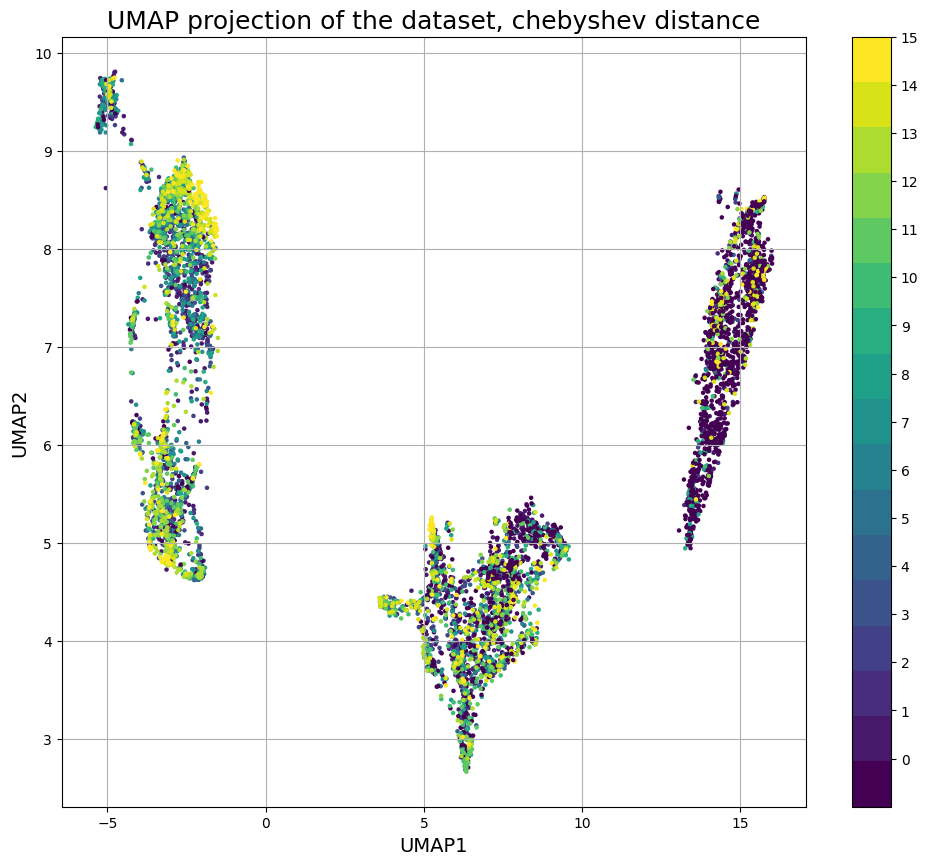

In [34]:
import umap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming 'final_features_df' is your DataFrame
# Drop non-numeric columns or convert them to suitable numeric formats if needed

# Selecting features - Assuming 'final_features_df' has the appropriate numeric columns
features = final_features_df.drop(columns=[
    'shape_label', 'glomerulus', 'closest_glomerular_shape',
    'distance_to_closest_glomerulus', "centroid_x", 'centroid_y', 
    'orientation', 'minr', 'minc', 'maxr', 'maxc', 'closest_glomerular_shape_id'
], axis=1)

# Apply MinMax scaling
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Setting up UMAP
reducer = umap.UMAP(n_neighbors=77, min_dist=0, n_components=2, metric="chebyshev")
umap_embedding = reducer.fit_transform(features_scaled)

# Prepare a colormap based on 'closest_glomerular_shape'
# Convert the categorical data to numeric for coloring
final_features_df['closest_glomerular_shape_id'] = pd.factorize(final_features_df['closest_glomerular_shape'])[0]
color_map = plt.get_cmap('viridis', np.unique(final_features_df['closest_glomerular_shape_id']).size)

# Plotting
plt.figure(figsize=(12, 10))
sc = plt.scatter(
    umap_embedding[:, 0], umap_embedding[:, 1], 
    c=final_features_df['closest_glomerular_shape_id'], cmap=color_map, s=5
)
plt.colorbar(sc, ticks=np.arange(np.unique(final_features_df['closest_glomerular_shape_id']).size))
plt.title('UMAP projection of the dataset, chebyshev distance', fontsize=18)
plt.xlabel('UMAP1', fontsize=14)
plt.ylabel('UMAP2', fontsize=14)
plt.grid(True)
plt.show()


In [16]:
features.shape

(6907, 627)

/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/j.maragall/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

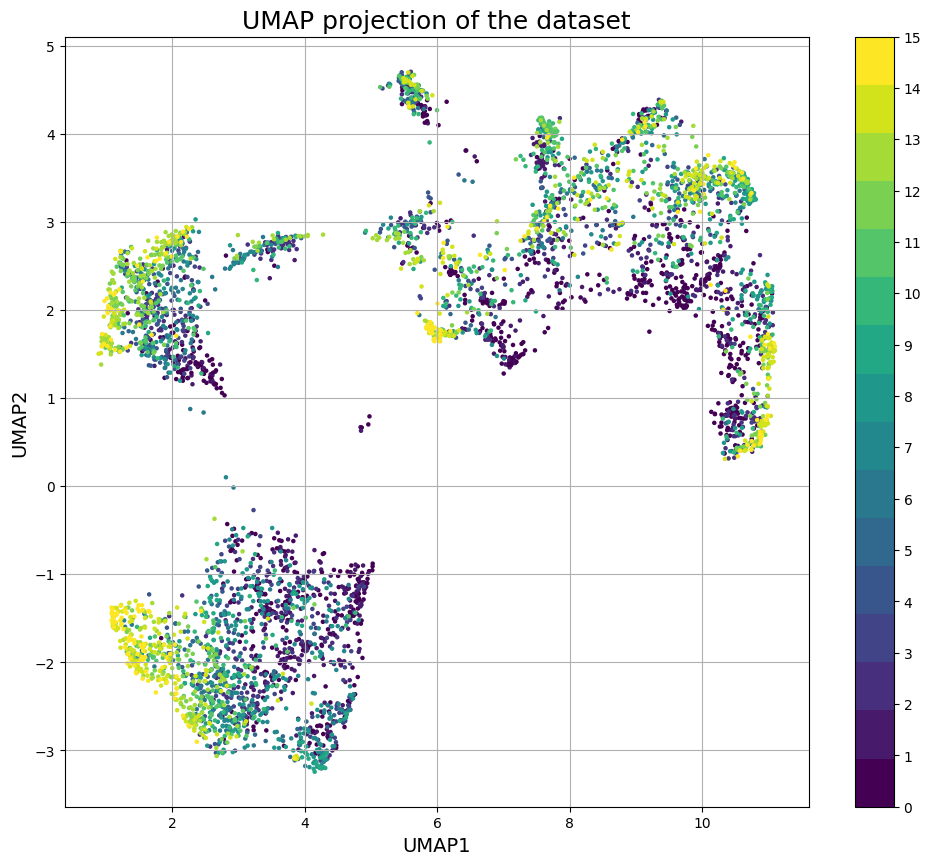

Closeness scores for each cluster:
Cluster 0: 0.3053
Cluster 1: 0.3069
Cluster 2: 0.2704
Cluster 3: 0.2989
Cluster 4: 0.2982
Cluster 5: 0.2442
Cluster 6: 0.2762
Cluster 7: 0.3028
Cluster 8: 0.2473
Cluster 9: 0.2428
Cluster 10: 0.2985
Cluster 11: 0.2488
Cluster 12: 0.2341
Cluster 13: 0.2739
Cluster 14: 0.2280
Cluster 15: 0.2429


In [38]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances

# Assuming 'final_features_df' is your DataFrame
# Drop non-numeric columns or convert them to suitable numeric formats if needed

# Convert the categorical data to numeric for filtering and coloring
final_features_df['closest_glomerular_shape_id'] = pd.factorize(final_features_df['closest_glomerular_shape'])[0]

# Filter out the cluster -1
filtered_df = final_features_df[final_features_df['closest_glomerular_shape_id'] != -1]

# Selecting features
features = filtered_df.drop(columns=[
    'shape_label', 'glomerulus', 'closest_glomerular_shape',
    'distance_to_closest_glomerulus', "centroid_x", 'centroid_y', 
    'orientation', 'minr', 'minc', 'maxr', 'maxc', 'closest_glomerular_shape_id'
], axis=1)

# Apply MinMax scaling
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Setting up UMAP
reducer = umap.UMAP(n_neighbors=77, min_dist=0, n_components=2, metric="euclidean")
umap_embedding = reducer.fit_transform(features_scaled)

# Adding UMAP embeddings back to the DataFrame for analysis
filtered_df['UMAP1'] = umap_embedding[:, 0]
filtered_df['UMAP2'] = umap_embedding[:, 1]

# Prepare a colormap
color_map = plt.get_cmap('viridis', np.unique(filtered_df['closest_glomerular_shape_id']).size)

# Plotting
plt.figure(figsize=(12, 10))
sc = plt.scatter(
    filtered_df['UMAP1'], filtered_df['UMAP2'], 
    c=filtered_df['closest_glomerular_shape_id'], cmap=color_map, s=5
)
plt.colorbar(sc, ticks=np.arange(np.unique(filtered_df['closest_glomerular_shape_id']).size))
plt.title('UMAP projection of the dataset', fontsize=18)
plt.xlabel('UMAP1', fontsize=14)
plt.ylabel('UMAP2', fontsize=14)
plt.grid(True)
plt.show()

# Calculate closeness of each cluster
closeness_scores = {}
for label in np.unique(filtered_df['closest_glomerular_shape_id']):
    cluster_points = umap_embedding[filtered_df['closest_glomerular_shape_id'] == label]
    if cluster_points.size > 0:
        centroid = np.mean(cluster_points, axis=0)
        distances = pairwise_distances(cluster_points, [centroid])
        closeness_scores[label] = 1 / np.mean(distances) if np.mean(distances) != 0 else 1

# Output closeness scores
print("Closeness scores for each cluster:")
for key, value in closeness_scores.items():
    print(f"Cluster {key}: {value:.4f}")
